# Triangulation error (Figure 1E)

In [4]:
import pickle
import seaborn as sns
import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import liftpose.legacy.stats as stats

def abs_error(abs_error,n_pts):
    error = np.zeros((abs_error.shape[0], n_pts))
    for k in range(n_pts):
        error[:, k] = np.mean(abs_error[:, 3*k:3*(k + 1)], axis=1)
        
    return error

# declare data parameters
par = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D', #mac/ubuntu path format
               #'data_dir'       : r'\Users\NeLy\Desktop\fly_tether', #windows path format
               'out_dir'        : '/data/LiftPose3D/fly_tether/fixed_cams',
               'train_subjects' : [1,2,3,4,5],
               'test_subjects'  : [6,7],
               'actions'        : ['all'],
               'cam_id'         : [2]}

#load
tri = pickle.load(open(os.path.join(par['out_dir'],'retriangulation.pkl'),'rb'))
lift = torch.load(os.path.join(par['out_dir'], 'test_results.pth.tar'))
stat = torch.load(os.path.join(par['out_dir'], 'stat_3d.pth.tar'))

#lifting error
dimensions = stat['targets_3d']
lift_tar = stats.unNormalize(lift['target'], stat['mean'][dimensions], stat['std'][dimensions])
print(lift_tar.shape)
lift_out = stats.unNormalize(lift['output'], stat['mean'][dimensions], stat['std'][dimensions])
absdiff = np.abs(lift_tar - lift_out)
n_pts = len(dimensions)//3
lift_error = abs_error(absdiff,n_pts)

#triangulation error
tri_3cam  = tri[(0, 1, 2, 4, 5, 6)]
tri_2cam = tri[(0, 1, 4, 6)]
absdiff = np.abs(tri_3cam - tri_2cam)
absdiff = np.reshape(absdiff, (absdiff.shape[0], absdiff.shape[1]*absdiff.shape[2]))
absdiff = absdiff[:,dimensions]
tri_error = abs_error(absdiff,n_pts)
nframes = tri_error.shape[0]

#Lift error
lift_error = lift_error[:len(tri_error)]

#average over limbs
tri_error = (tri_error[:,0:4] + tri_error[:,4:8] + tri_error[:,8:12] )/3
lift_error = (lift_error[:,0:4] + lift_error[:,4:8] + lift_error[:,8:12] )/3

#add overall error
tri_error = np.hstack((tri_error,np.mean(tri_error,axis=1)[:,None]))
lift_error = np.hstack((lift_error,np.mean(lift_error,axis=1)[:,None]))

#make pandas dataframe
tri_error=tri_error.flatten()
lift_error=lift_error.flatten()
error = np.concatenate((tri_error,lift_error))
error = pd.DataFrame({'joint': ['coxa-femur', 'femur-tibia', 'tibia-tarsus', 'tarsus-tip', 'overall'] * nframes * 2,
                   'method': ['tri' for i in range(len(tri_error))] + ['lift' for i in range(len(tri_error))],
                   'error': error})

(18979, 36)


(0.0, 0.125)

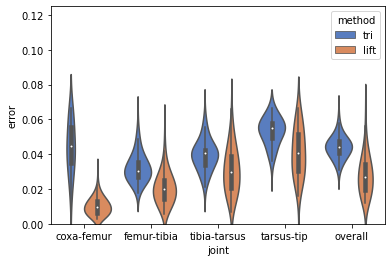

In [5]:
q = error.quantile(q=0.95)
error = error[error['error']<q[0]]

fig = plt.figure()
sns.violinplot(x="joint", y="error", hue="method", data=error, palette="muted",bw=0.7,ax=plt.gca())
plt.ylim(0, 0.125)